In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jun 24 18:47:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory

ram = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM.'.format(ram))
if ram < 20:
    print('To enable a high-RAM runtime, select the Runtime > "Change runtime type", then select High-RAM in the Runtime shape dropdown '
          'and then re-execute this cell.')
else:
    print('You are using a high-RAM runtime.')

Your runtime has 27.3 gigabytes of available RAM.
You are using a high-RAM runtime.


In [4]:
from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as exception:
    print(exception)

In [5]:
from keras.utils.vis_utils import plot_model
from tensorflow import device
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import optimizers

import csv
import datetime
import gc
import h5py
import numpy as np
import os
import re

In [6]:
berlin_files = '/content/gdrive/My Drive/Licenta/Traffic4Cast/Berlin/files/training'
istanbul_files = '/content/gdrive/My Drive/Licenta/Traffic4Cast/Istanbul/files/training'
moscow_files = '/content/gdrive/My Drive/Licenta/Traffic4Cast/Moscow/files/training'

checkpoints = '/content/gdrive/My Drive/Licenta/Traffic4Cast/All/checkpoints/auto_encoder_12'
logs = '/content/gdrive/My Drive/Licenta/Traffic4Cast/All/logs/auto_encoder_12/training/logs.csv'

In [7]:
def get_file_names(berlin_files, istanbul_files, moscow_files):
    file_names = os.listdir(berlin_files) + os.listdir(istanbul_files) + os.listdir(moscow_files)
    np.random.shuffle(file_names)
    return file_names

In [8]:
def load_data(file_path):
    file = h5py.File(file_path, 'r')
    group_key = list(file.keys())[0]
    data = np.array(file[group_key][:], dtype=np.float32)
    file.close()
    data = np.take(data, np.arange(8), axis=-1)  # keep only the dynamic channels
    data = np.array(np.split(data, 12))  # 12 * (12 + 12) = 288
    np.random.shuffle(data)  # shuffle the 12 batches
    return data / 255.0

In [9]:
def get_model():
    inputs = layers.Input(shape=(12, 495, 436, 8), name='inputs')

    enc_conv_lstm_0 = layers.ConvLSTM2D(filters=12, kernel_size=(6, 6), padding='same',
                                        return_sequences=True, return_state=False,
                                        name='enc_conv_lstm_0')(inputs)
    pool = layers.MaxPool3D(pool_size=(1, 2, 2), padding='valid')(enc_conv_lstm_0)
    enc_conv_lstm_1 = layers.ConvLSTM2D(filters=12, kernel_size=(6, 6), padding='same',
                                        return_sequences=True, return_state=False,
                                        name='enc_conv_lstm_1')(pool)
    enc_conv_lstm_2 = layers.ConvLSTM2D(filters=12, kernel_size=(6, 6), padding='same',
                                        return_sequences=False, return_state=True,
                                        name='enc_conv_lstm_2')(enc_conv_lstm_1)[-1]

    flatten = layers.Flatten(name='flatten')(enc_conv_lstm_2)
    repeat_vector = layers.RepeatVector(12, name='repeat_vector')(flatten)
    reshape = layers.Reshape((12, 247, 218, 12), name='reshape')(repeat_vector)

    skip_conn_0 = layers.Add(name='skip_conn_0')([reshape, enc_conv_lstm_2])
    dec_conv_lstm_0 = layers.ConvLSTM2D(filters=12, kernel_size=(6, 6), padding='same',
                                        return_sequences=True, return_state=False,
                                        name='dec_conv_lstm_0')(skip_conn_0)
    skip_conn_1 = layers.Add(name='skip_conn_1')([dec_conv_lstm_0, enc_conv_lstm_1])
    conv_transpose = layers.Conv3DTranspose(filters=12, kernel_size=(1, 2, 2),
                                            strides=(1, 2, 2), output_padding=(0, 1, 0),
                                            name='conv_transpose')(skip_conn_1)
    dec_conv_lstm_1 = layers.ConvLSTM2D(filters=12, kernel_size=(6, 6), padding='same',
                                        return_sequences=True, return_state=False,
                                        name='dec_conv_lstm_1')(conv_transpose)
    skip_conn_2 = layers.Add(name='skip_conn_2')([dec_conv_lstm_1, enc_conv_lstm_0])
    dec_conv_lstm_2 = layers.ConvLSTM2D(filters=8, kernel_size=(6, 6), padding='same',
                                        return_sequences=True, return_state=False,
                                        name='dec_conv_lstm_2')(skip_conn_2)

    return models.Model(inputs=inputs, outputs=dec_conv_lstm_2)

In [10]:
with device('gpu:0'):
    model = get_model()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss=losses.mean_squared_error)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 12, 495, 436 0                                            
__________________________________________________________________________________________________
enc_conv_lstm_0 (ConvLSTM2D)    (None, 12, 495, 436, 34608       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 12, 247, 218, 0           enc_conv_lstm_0[0][0]            
__________________________________________________________________________________________________
enc_conv_lstm_1 (ConvLSTM2D)    (None, 12, 247, 218, 41520       max_pooling3d[0][0]              
______________________________________________________________________________________________

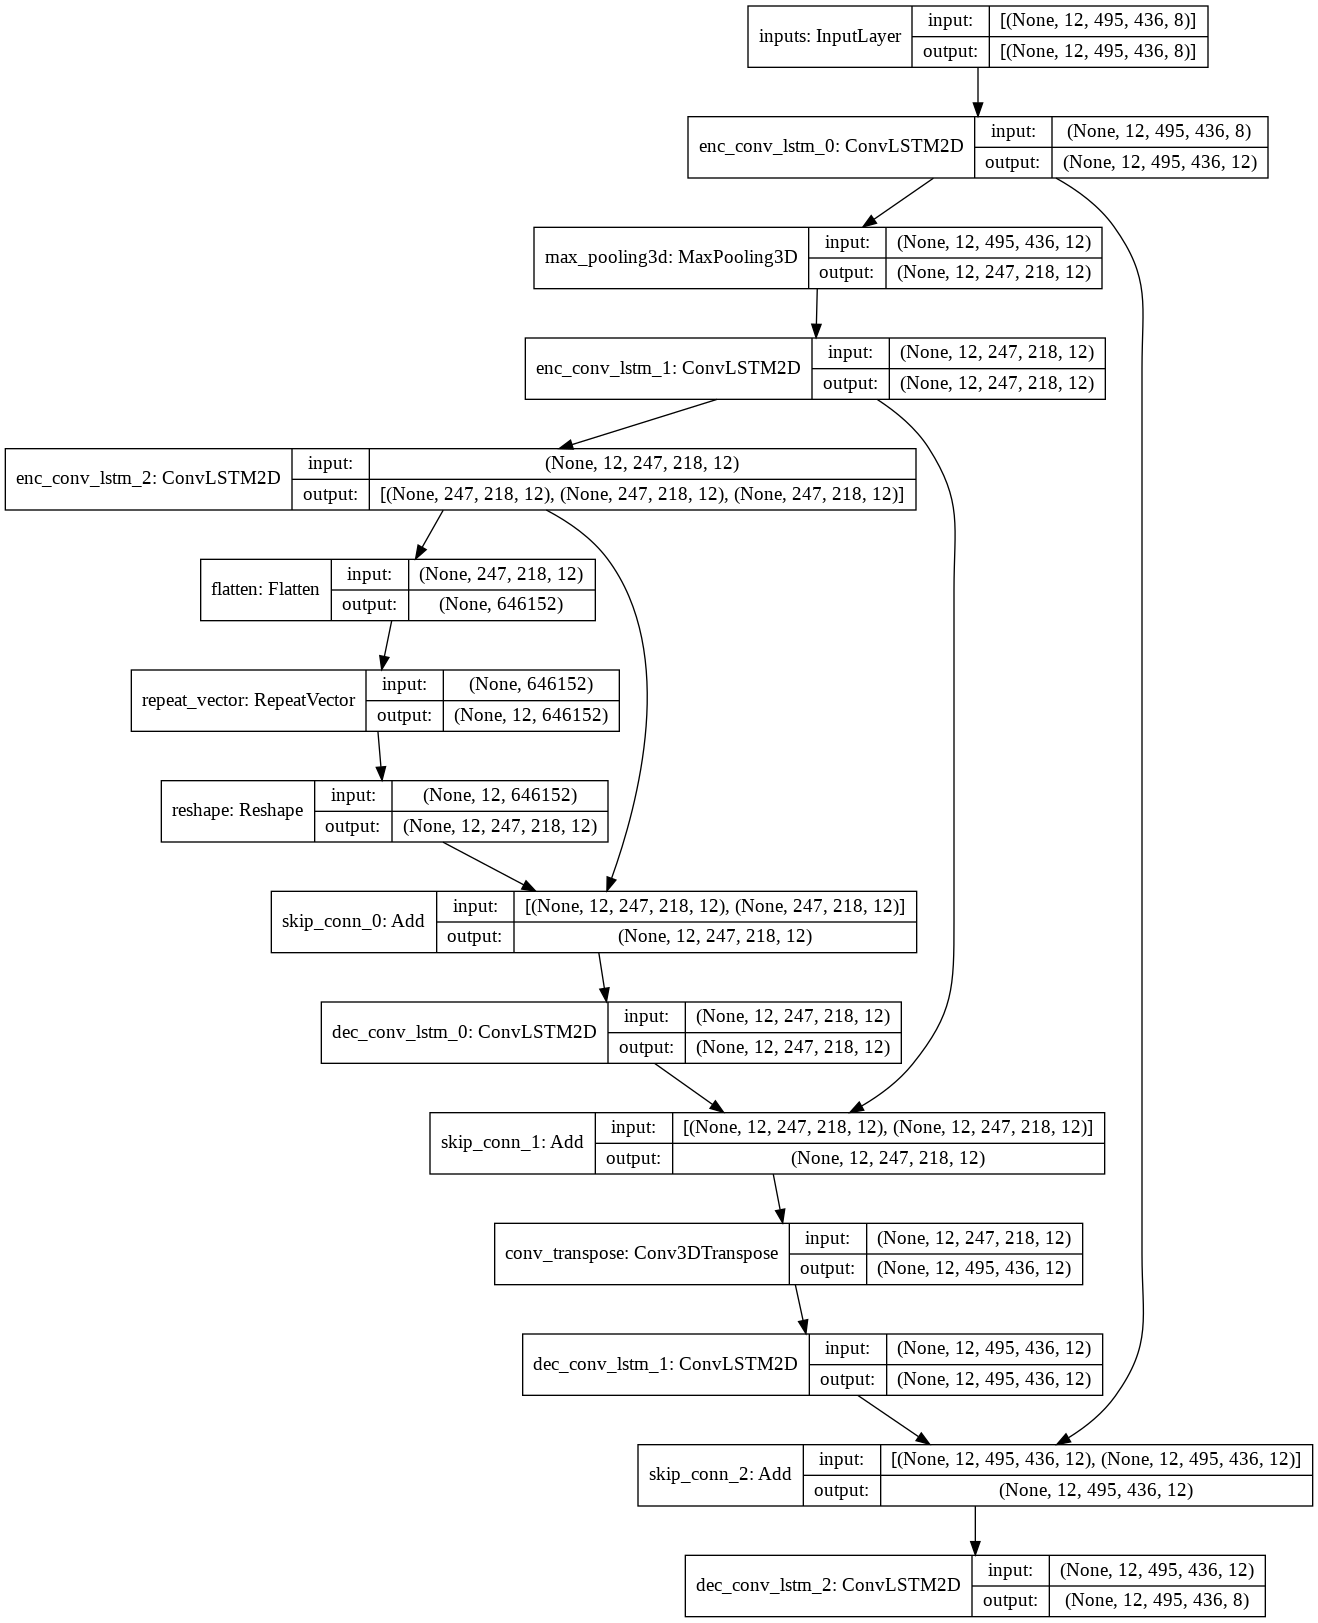

In [11]:
plot_model(model, to_file='auto_encoder_12.png', show_shapes=True, show_layer_names=True)

In [ ]:
file_names = get_file_names(berlin_files, istanbul_files, moscow_files)

log_file = open(logs, 'w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(['epoch', 'file', 'loss'])
log_file.flush()

In [ ]:
for epoch in range(2):
    print('epoch:', epoch)
    for index, file_name in enumerate(file_names):
        print('file:', index)
        if 'berlin' in file_name:
            data = load_data(os.path.join(berlin_files, file_name))
        elif 'istanbul' in file_name:
            data = load_data(os.path.join(istanbul_files, file_name))
        else:
            data = load_data(os.path.join(moscow_files, file_name))
        losses = np.zeros(shape=(4,), dtype=np.float64)
        for batch in range(0, 12, 3):
            inputs = data[batch:batch + 3, :12]
            outputs = data[batch:batch + 3, 12:]
            with device('gpu:0'):
                history = model.fit(inputs, outputs, epochs=1, batch_size=1)
                losses[batch // 3] = history.history['loss'][0]
        log_writer.writerow([epoch, file_name, np.mean(losses, dtype=np.float64)])
        log_file.flush()
        gc.collect()
    model.save(os.path.join(checkpoints, 'model_{}.h5'.format(epoch)))

In [ ]:
log_file.close()